# Examples of scheduled circuit  (circuit with duration)

## Current status
1. [x] Adding a Delay instruction for circuits
2. [x] Two scheduling passes for implementing ALAP and ASAP by inserting Delays on the DAGCircuit.
```
from qiskit.transpiler.passes.scheduling import ASAPSchedule, ALAPSchedule
dag_with_delays = ALAPSchedule(backend_properties).run(dag)
```
3. [x] A simple scheduled_circuit.draw() to visualize timed blocks on the qubits
4. [x] Another scheduler that approximates the schedule by timesteps.
5. [x] Assembly to Qobj.
```
For qobj instructions something like:
{"name": "delay", "qubits": [i], "params": [length], "duration": length}  # "duration" may be optional
{"name": "cx", "qubits": [i,j], "duration": 320}  # "duration" may be optional
and
{"name": "timestep", "qubits": [0,...,N-1], "params": [length], "duration": 0}  # "duration" may be optional
{"name": "barrier", "qubits": [0,...,N-1], "duration": 0}  # "duration" may be optional
the lengths would have to be relative to a dt parameter in the noise model 
```
6. [x] Integrate into transpile().
```
scehduled_circuit = qiskit.compiler.transpile(circuit, backend, , coupling_map, gate_lengths = [("cx", [0, 1], 300), ...],
                                              layout_method=..., routing_method=..., scheduling_method=...)
```
7. [x] A sequencer: Schedulce circuit -> Pulse schedule
```
pulse_schedule = qiskit.compiler.sequence(scheduled_circuit, backend)
```

In [1]:
from qiskit import transpile
from qiskit import QuantumCircuit
from qiskit.test.mock.backends import FakeParis
backend = FakeParis()
print(f"dt={backend.configuration().dt}")

dt=2.2222222222222221e-10


## Manual construction of T2 experiment

In [2]:
qc = QuantumCircuit(1, 1, name="t2_experiment")
qc.h(0)
qc.delay(500, 0, unit='ns')
qc.h(0)
qc.measure(0, 0)
qc.draw()

┌───┐┌────────────┐┌───┐┌─┐
q_0: ┤ H ├┤ DELAY(500) ├┤ H ├┤M├
     └───┘└────────────┘└───┘└╥┘
c_0: ═════════════════════════╩═

In [3]:
# 500 ns = 2250 dt in FakeParis backend
sc = transpile(qc, backend, scheduling_method='alap')
sc.draw(output='timeline', qubits=[0])

         |--------------------------------------------------------------|
q_0 -> 0 | U2(0,pi)[160] | DELAY[2250] | U2(0,pi)[160] | MEASURE[19200] |
         |--------------------------------------------------------------|

## Schedule circuits with scheduling passes

In [4]:
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.transpiler.instruction_durations import InstructionDurations
from qiskit.transpiler.passes.scheduling.asap import ASAPSchedule
from qiskit.transpiler.passes.scheduling.alap import ALAPSchedule

In [5]:
qc = QuantumCircuit(2, name="bell_with_delay")
qc.h(0)
qc.delay(500, 1)
qc.cx(0,1)
qc.draw()

┌───┐          
q_0: ────┤ H ├───────■──
     ┌───┴───┴────┐┌─┴─┐
q_1: ┤ DELAY(500) ├┤ X ├
     └────────────┘└───┘

In [6]:
sc = transpile(qc, backend, scheduling_method='alap')
sc.draw(output='timeline', qubits=[0,1,2])

               |--------------------------------------------|
      q_0 -> 0 | DELAY[340] | U2(0,pi)[160] | CX(0,1)[1408] |
      q_1 -> 1 |         DELAY[500]         | CX(0,1)[1408] |
ancilla_0 -> 2 |                DELAY[1908]                 |
               |--------------------------------------------|

The above is the same as below.

In [7]:
transpiled = transpile(qc, backend, basis_gates=['u1', 'u2', 'u3', 'cx', 'delay'])
dag = circuit_to_dag(transpiled)
dag_with_delays = ALAPSchedule(InstructionDurations.from_backend(backend)).run(dag)
scheduled = dag_to_circuit(dag_with_delays)
scheduled.draw(output='timeline', qubits=[0,1,2])

     |--------------------------------------------|
q_0: | DELAY[340] | U2(0,pi)[160] | CX(0,1)[1408] |
q_1: |         DELAY[500]         | CX(0,1)[1408] |
q_2: |                DELAY[1908]                 |
     |--------------------------------------------|

###  ASAP or ALAP Schedule

In [8]:
qc = QuantumCircuit(2, name="h2")
qc.h(0)
qc.x(1)
qc.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ X ├
     └───┘

In [9]:
#ASAP
sc = transpile(qc, backend, scheduling_method='asap', coupling_map=[[0,1]])
sc.draw(output='timeline')

         |----------------------------|
q_0 -> 0 | U2(0,pi)[160] | DELAY[160] |
q_1 -> 1 |      U3(pi,0,pi)[320]      |
         |----------------------------|

In [10]:
#ALAP
sc = transpile(qc, backend, scheduling_method='alap', coupling_map=[[0,1]])
sc.draw(output='timeline')

         |----------------------------|
q_0 -> 0 | DELAY[160] | U2(0,pi)[160] |
q_1 -> 1 |      U3(pi,0,pi)[320]      |
         |----------------------------|

###  Schedule passes convert the duration units into dt (values are rounded)

In [11]:
bell = QuantumCircuit(2, name="bell_with_manual_delay_ns")
bell.h(0)
bell.delay(999, 1, unit='ns')
bell.cx(0,1)
sc_bell = transpile(bell, backend, scheduling_method='alap', coupling_map=[[0,1]])
sc_bell.draw(output='timeline')

/Users/itoko/swd/qiskit-dev/qiskit-sdk-py/qiskit/transpiler/passes/scheduling/delayindt.py:71: UserWarning: Duration of delay is rounded to 4496 dt = 9.991111e-07 s from 9.990000e-07
  UserWarning)


         |---------------------------------------------|
q_0 -> 0 | DELAY[4336] | U2(0,pi)[160] | CX(0,1)[1408] |
q_1 -> 1 |         DELAY[4496]         | CX(0,1)[1408] |
         |---------------------------------------------|

In [12]:
bell = QuantumCircuit(2, name="bell_with_manual_delay_unitless")
bell.h(0)
bell.delay(999, 1)
bell.cx(0,1)
sc_bell = transpile(bell, backend, scheduling_method='alap', coupling_map=[[0,1]])
sc_bell.draw(output='timeline')

         |--------------------------------------------|
q_0 -> 0 | DELAY[839] | U2(0,pi)[160] | CX(0,1)[1408] |
q_1 -> 1 |         DELAY[999]         | CX(0,1)[1408] |
         |--------------------------------------------|

##  Assembly qobj

In [13]:
qc = QuantumCircuit(2, name="bell_with_delay")
qc.h(0)
qc.delay(500, 1, unit='ns')
qc.cx(0,1)
qc.measure_all()
qc.draw()

┌───┐           ░ ┌─┐   
   q_0: ────┤ H ├───────■───░─┤M├───
        ┌───┴───┴────┐┌─┴─┐ ░ └╥┘┌─┐
   q_1: ┤ DELAY(500) ├┤ X ├─░──╫─┤M├
        └────────────┘└───┘ ░  ║ └╥┘
meas_0: ═══════════════════════╩══╬═
                                  ║ 
meas_1: ══════════════════════════╩═

In [14]:
sc = transpile(qc, backend, scheduling_method='alap', coupling_map=[[0,1]])
sc.draw(output='timeline')

         |----------------------------------------------------------------------
q_0 -> 0 | DELAY[2090] | U2(0,pi)[160] | CX(0,1)[1408] | BARRIER(0,1)[0] | MEASU
q_1 -> 1 |         DELAY[2250]         | CX(0,1)[1408] | BARRIER(0,1)[0] | MEASU
         |----------------------------------------------------------------------
----------|
RE[19200] |
RE[19200] |
----------|

In [15]:
from qiskit import assemble
qobj = assemble(sc, backend=backend, shots=1000)
print("\n".join(str(qobj).split('\n')[-35:]))


	Instruction: delay
		params: [2090]
		qubits: [0]
		duration: 2090

	Instruction: u2
		params: [0.0, 3.141592653589793]
		qubits: [0]
		duration: 160

	Instruction: delay
		params: [2250]
		qubits: [1]
		duration: 2250

	Instruction: cx
		qubits: [0, 1]
		duration: 1408

	Instruction: barrier
		qubits: [0, 1]
		duration: 0

	Instruction: measure
		qubits: [0]
		memory: [0]
		duration: 19200

	Instruction: measure
		qubits: [1]
		memory: [1]
		duration: 19200




In [16]:
transpiled = transpile(qc, backend=backend, basis_gates=['u1', 'u2', 'u3', 'cx', 'delay'])
qobj = assemble(transpiled, backend=backend, shots=1000)
print("\n".join(str(qobj).split('\n')[-25:]))


	Instruction: u2
		params: [0.0, 3.141592653589793]
		qubits: [0]

	Instruction: delay
		params: [500]
		qubits: [1]
		duration: 500

	Instruction: cx
		qubits: [0, 1]

	Instruction: barrier
		qubits: [0, 1]

	Instruction: measure
		qubits: [0]
		memory: [0]

	Instruction: measure
		qubits: [1]
		memory: [1]




##  Timesteps

In [17]:
qc = QuantumCircuit(2, name="bell_with_delay")
qc.h(0)
qc.delay(500, 1)
qc.cx(0,1)
qc.measure_all()
qc.draw()

┌───┐           ░ ┌─┐   
   q_0: ────┤ H ├───────■───░─┤M├───
        ┌───┴───┴────┐┌─┴─┐ ░ └╥┘┌─┐
   q_1: ┤ DELAY(500) ├┤ X ├─░──╫─┤M├
        └────────────┘└───┘ ░  ║ └╥┘
meas_0: ═══════════════════════╩══╬═
                                  ║ 
meas_1: ══════════════════════════╩═

In [18]:
sc = transpile(qc, backend, scheduling_method='alap_timestep', coupling_map=[[0,1]])
sc.draw(output='timeline')

         |----------------------------------------------------------------------
q_0 -> 0 | DELAY[340] | TIMESTEP(340)(0,1)[0] | U2(0,pi)[160] | TIMESTEP(160)(0,
q_1 -> 1 | DELAY[340] | TIMESTEP(340)(0,1)[0] |   DELAY[160]  | TIMESTEP(160)(0,
         |----------------------------------------------------------------------
--------------------------------------------------------------------------------
1)[0] | CX(0,1)[1408] | TIMESTEP(1408)(0,1)[0] | BARRIER(0,1)[0] | MEASURE[19200
1)[0] | CX(0,1)[1408] | TIMESTEP(1408)(0,1)[0] | BARRIER(0,1)[0] | MEASURE[19200
--------------------------------------------------------------------------------
----------------------------|
] | TIMESTEP(19200)(0,1)[0] |
] | TIMESTEP(19200)(0,1)[0] |
----------------------------|

In [19]:
from qiskit import assemble
qobj = assemble(sc, backend=backend, shots=1000)
print("\n".join(str(qobj).split('\n')))

QASM Qobj: 96366745-cfcf-4231-a056-2ca3992858f0:
Config: {'memory': False,
 'memory_slots': 2,
 'n_qubits': 2,
 'parameter_binds': [],
 'shots': 1000}
Header: {'backend_name': 'fake_paris', 'backend_version': '1.0.3'}
Experiments:

QASM Experiment:
Header:
{'clbit_labels': [['meas', 0], ['meas', 1]],
 'creg_sizes': [['meas', 2]],
 'memory_slots': 2,
 'n_qubits': 2,
 'name': 'bell_with_delay',
 'qreg_sizes': [['q', 2]],
 'qubit_labels': [['q', 0], ['q', 1]]}
Config:
{'memory_slots': 2, 'n_qubits': 2}

	Instruction: delay
		params: [340]
		qubits: [0]
		duration: 340

	Instruction: delay
		params: [340]
		qubits: [1]
		duration: 340

	Instruction: timestep
		params: [340]
		qubits: [0, 1]
		duration: 0

	Instruction: u2
		params: [0.0, 3.141592653589793]
		qubits: [0]
		duration: 160

	Instruction: delay
		params: [160]
		qubits: [1]
		duration: 160

	Instruction: timestep
		params: [160]
		qubits: [0, 1]
		duration: 0

	Instruction: cx
		qubits: [0, 1]
		duration: 1408

	Instruction: ti

In [20]:
import numpy as np
from qiskit.extensions import UnitaryGate
U20 = UnitaryGate(np.eye(2), label="U20")
U20.duration = 20
U7 = UnitaryGate(np.eye(2), label="U7")
U7.duration = 7
qc = QuantumCircuit(2, name="U20-U7")
qc.append(U20, [0])
qc.append(U20, [0])
qc.append(U7, [1])
qc.append(U7, [1])
qc.append(U7, [1])
qc.append(U7, [1])
qc.append(U7, [1])
qc.append(U7, [1])
qc.draw()

┌─────┐┌─────┐                        
q_0: ┤ U20 ├┤ U20 ├────────────────────────
     └┬────┤└┬────┤┌────┐┌────┐┌────┐┌────┐
q_1: ─┤ U7 ├─┤ U7 ├┤ U7 ├┤ U7 ├┤ U7 ├┤ U7 ├
      └────┘ └────┘└────┘└────┘└────┘└────┘

In [21]:
sc = transpile(qc, backend, basis_gates=['unitary'], scheduling_method='alap_timestep', coupling_map=[[0,1]])
sc.draw(output='timeline', qubits=[0, 1])

         |----------------------------------------------------------------------
q_0 -> 0 | DELAY[7] | TIMESTEP(7)(0,1)[0] | DELAY[7] | TIMESTEP(7)(0,1)[0] |    
q_1 -> 1 |    U7    | TIMESTEP(7)(0,1)[0] |    U7    | TIMESTEP(7)(0,1)[0] | DEL
         |----------------------------------------------------------------------
---------------------------------------------------------------------------|
  U20       | TIMESTEP(20)(0,1)[0] |      U20       | TIMESTEP(20)(0,1)[0] |
AY[6] |U7|U7| TIMESTEP(20)(0,1)[0] | DELAY[6] |U7|U7| TIMESTEP(20)(0,1)[0] |
---------------------------------------------------------------------------|

## Second path (circuit -> scheduled circuit -> pulse schedule)

In [22]:
qc = QuantumCircuit(2, name="bell")
qc.h(0)
qc.cx(0,1)
qc.measure_all()
qc.draw()

┌───┐      ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤M├───
        └───┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░──╫─┤M├
             └───┘ ░  ║ └╥┘
meas_0: ══════════════╩══╬═
                         ║ 
meas_1: ═════════════════╩═

### Second path (circuit -> scheduled circuit -> pulse schedule)

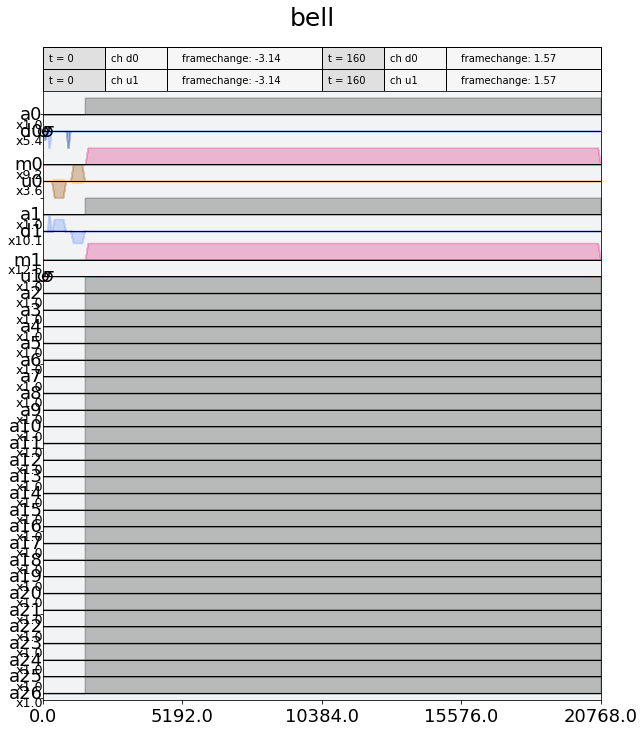

In [23]:
from qiskit.compiler.sequence import sequence
sc = transpile(qc, backend, scheduling_method='alap', coupling_map=[[0,1],[1,2]])
sched = sequence(sc, backend)
sched.draw()

### Current path (circuit -> unrolled circuit -> pulse schedule)

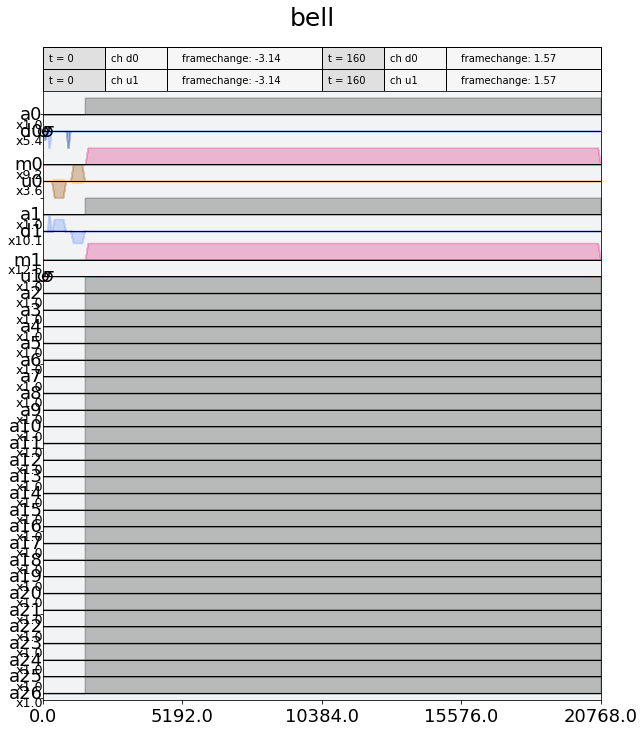

In [24]:
from qiskit import schedule
# sched_path1 = schedule(qc, backend)  # we cannot do this because schedule requires unrolled circuit
sched_path1 = schedule(qc.decompose(), backend)  # works in this case
# You need transpile() in general to unroll
# transpiled = transpile(qc, backend, basis_gates=['u1', 'u2', 'u3', 'cx'], coupling_map=[[0,1],[1,2]])
# sched_path1 = schedule(transpiled, backend)
sched_path1.draw()

## InstructionDurations

In [25]:
durations = InstructionDurations.from_backend(backend)
durations.get('cx', [0, 1])

1408

In [26]:
durations.get('u2', [0])

160

### use durations defined in backend

In [27]:
qc = QuantumCircuit(2)
qc.h(0)
qc.delay(500, 1)
qc.cx(0,1)
print(qc)

         ┌───┐          
q_0: ────┤ H ├───────■──
     ┌───┴───┴────┐┌─┴─┐
q_1: ┤ DELAY(500) ├┤ X ├
     └────────────┘└───┘


In [28]:
scheduled = transpile(qc,
                      backend=backend,
                      scheduling_method='asap')
scheduled.draw(output='timeline', qubits=[0, 1])

         |--------------------------------------------|
q_0 -> 0 | U2(0,pi)[160] | DELAY[340] | CX(0,1)[1408] |
q_1 -> 1 |         DELAY[500]         | CX(0,1)[1408] |
         |--------------------------------------------|

### overwite with custom durations

In [29]:
scheduled = transpile(qc,
                      backend=backend,
                      scheduling_method='asap',
                      instruction_durations=[('cx', [0, 1], 1000)])
scheduled.draw(output='timeline', qubits=[0, 1])

         |--------------------------------------------|
q_0 -> 0 | U2(0,pi)[160] | DELAY[340] | CX(0,1)[1000] |
q_1 -> 1 |         DELAY[500]         | CX(0,1)[1000] |
         |--------------------------------------------|

### full custom durations

In [30]:
scheduled = transpile(qc,
                      # no backend
                      scheduling_method='asap',
                      instruction_durations=[('u2', [0], 100), ('cx', [0, 1], 1000)],
                      basis_gates=['u1', 'u2', 'u3', 'cx', 'delay'])
scheduled.draw(output='timeline', qubits=[0, 1])

     |--------------------------------------------|
q_0: | U2(0,pi)[100] | DELAY[400] | CX(0,1)[1000] |
q_1: |         DELAY[500]         | CX(0,1)[1000] |
     |--------------------------------------------|

##  Issues identified

- Should we output delay when qasm()? Will delay be included in QASM3? (related to https://github.com/Qiskit/qiskit-terra/issues/4312)
- backend.properties should have all info about instruction durations.
- How to distinguish regular circuit and scheduled circuit in the code level: `if self.duration` or `if isinstance(qc, ScheduleCircuit)` (currently `if self.duration`)

##  Resolved

1. Ignoring idle qubits should be done before scheduler (not in the scheduler)
2. Implemented helper function to get duration of each instruction -> qiskit.transpiler.instruction_durations.InstructionDurations.